In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import re
import random

#read in all 5 documents, all store different info with nothing but keys duplicated
order_meta = pd.read_csv('orders.csv')
aisles = pd.read_csv('aisles.csv')
depts = pd.read_csv('departments.csv')
order_products = pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')


In [318]:
orders[:3]

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0


In [319]:
#join info about orders with info within orders, keep only rows 1:1 for ordered products
orders_meta_products = order_products.merge(order_meta, how = 'left', left_on ='order_id', 
                                            right_on = 'order_id') 
print(orders_meta_products.shape)
display(orders_meta_products[:3])

#add in product names and keys for depts and aisels to master table of products
orders_product_names = products.merge(orders_meta_products, how = 'right', left_on ='product_id', 
                                      right_on = 'product_id')

print(orders_product_names.shape)
display(orders_product_names[:3])

#add in fields from aisles and depts into one master table that contains all info
#about a given instance of a product being ordered
master = orders_product_names.merge(aisles, how = 'left').merge(depts, how = 'left')

print(master.shape)
display(master[:3])


(1384617, 10)


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
2,1,10246,3,0,112108,train,4,4,10,9.0


(1384617, 13)


,product_id,product_name,aisle_id,department_id,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,49302,Bulgarian Yogurt,120,16,1,1,1,112108,train,4,4,10,9.0
1,49302,Bulgarian Yogurt,120,16,816049,7,1,47901,train,14,4,6,16.0
2,49302,Bulgarian Yogurt,120,16,1242203,1,1,2993,train,15,0,7,7.0


(1384617, 15)


,product_id,product_name,aisle_id,department_id,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,49302,Bulgarian Yogurt,120,16,1,1,1,112108,train,4,4,10,9.0,yogurt,dairy eggs
1,49302,Bulgarian Yogurt,120,16,816049,7,1,47901,train,14,4,6,16.0,yogurt,dairy eggs
2,49302,Bulgarian Yogurt,120,16,1242203,1,1,2993,train,15,0,7,7.0,yogurt,dairy eggs


The function assign_time_cat written below was written prior to its sister function, assign_time_num which was added once it became apparent that having a clear numerical order was more useful for keeping things in logical order during aggregation.

In [320]:
def assign_time_cat(row):
    
    if row >= 1 and row <5:
        time = 'Late Night'
    elif row >= 5 and row <9:
        time = 'Early Morning'
    elif row >= 9 and row <13:
        time = 'Morning'
    elif row >= 13 and row <17:
        time = 'Afternoon'
    elif row >= 17 and row <21:
        time = 'Evening'
    else:
        time = 'Night'
    
    return time
    
master['Time Category']  = master['order_hour_of_day'].apply(assign_time_cat) 

#master[['Time Category','order_hour_of_day']][:30]        

In [321]:
#assign a category number to a 4 hour block of day, corresponding to comment descriptions below
def assign_time_num(row):
    if row >= 1 and row <5:    #Late Night
        time = 0
    elif row >= 5 and row <9:  #Early Morning
        time = 1
    elif row >= 9 and row <13: #Morning
        time = 2
    elif row >= 13 and row <17:#Afternoon
        time = 3
    elif row >= 17 and row <21:#Evening
        time = 4
    else:
        time = 5               #Night, hours 21,22,23,0
    
    return time
    
master['Time Number']  = master['order_hour_of_day'].apply(assign_time_num) 

#mapping dictionary used to logically link numerical values to their meanings
#commonly called when 'Time Number' field is used for aggregation
time_day_cat_dict = {0 :'Late Night',1:'Early Morning',2:'Morning',3:'Afternoon',4:'Evening',5:'Night'}



In [322]:
#save original master df to longer named varible prior to dropping
#could be called later without needing to redo merging and loading operations
master_all = master

master = master.drop(['add_to_cart_order','reordered','user_id',
                        'eval_set', 'order_number','days_since_prior_order'], axis = 1)

In [323]:
#early exploratory call to investigate distribution of purchases by department and time of day
dept_time = pd.crosstab(master['department'],master['Time Number'], margins = True, normalize = 'index')
dept_time = dept_time.rename(columns = time_day_cat_dict)
dept_time


Time Number,Late Night,Early Morning,Morning,Afternoon,Evening,Night
department,,,,,,
alcohol,0.007503,0.053412,0.304037,0.390497,0.207931,0.036620
babies,0.011110,0.114986,0.298106,0.311224,0.187672,0.076902
bakery,0.009071,0.089453,0.308881,0.334711,0.199570,0.058313
beverages,0.010838,0.084562,0.323238,0.325404,0.198753,0.057205
breakfast,0.010169,0.091525,0.314169,0.320983,0.199898,0.063254
bulk,0.012509,0.082414,0.307579,0.319352,0.203091,0.075055
canned goods,0.009509,0.081369,0.317250,0.337956,0.190090,0.063826
dairy eggs,0.009477,0.091845,0.308402,0.329770,0.196336,0.064169
deli,0.010002,0.082838,0.307579,0.337721,0.200763,0.061096


In [324]:
#generate counts for unique items in descending order by count
freq = master['product_id'].value_counts()
#reset product_id info index to column and provide default numerical index
freq = freq.reset_index()
#rename columns to familiar names
freq.columns = ['product_id', 'instance_count']
display(freq[:8])

#a hasty query to find what the border is for top 100 most frequently ordered item
display(freq.iloc[90:102])
#instance_count > 1350
print(len(freq), freq['instance_count'].sum())

#put counts back into table
master = master.merge(freq, how = 'left')

#generate feature for items purchased only once
master['Uncommon?'] = master['instance_count'] == 1
#generate feature for top 100 most commonly purchased items
master['Staple?'] = master['instance_count'] > 1350
master['Staple?'].value_counts()


,product_id,instance_count
0,24852,18726
1,13176,15480
2,21137,10894
3,21903,9784
4,47626,8135
5,47766,7409
6,47209,7293
7,16797,6494


,product_id,instance_count
90,47144,1465
91,40604,1449
92,5025,1445
93,42736,1435
94,21709,1423
95,8193,1418
96,9387,1379
97,37687,1362
98,20995,1361
99,34243,1351


39123 1384617


False    1069039
True      315578
Name: Staple?, dtype: int64

In [325]:
#link aisle and dept tables (confirm that aisel is subgroup of dept)
#grouped by department, then aisle and selected first entry name as sample for grouping
aisle_dept = master.groupby(['department', 'aisle']).first()[['product_name','aisle_id','department_id']]
#sorted by number to improve organization
aisle_dept = aisle_dept.sort_values(['department_id','aisle_id'])
aisle_dept[:5]

#used excel sheet to help determine how to classify JunkFood? and Prepared? features, maybe others
aisle_dept.to_excel('aisle_dept.xls')

In [326]:
#generate column asking whether string 'Organic' is present in item name
master['Organic?'] = master['product_name'].str.contains('Organic', regex = False)

#generate all of the features that refer to aisle/dept categories
master['Alcohol?'] = master['department_id'] == 5
master['Produce?'] = master['department_id'] == 4
master['Beverage?'] = master['department_id'] == 7
master['Household?'] = master['department_id'] == 17

master['PetsBabies?'] = (master['department_id'] == 8) | (master['department_id'] == 18)
master['NonFood?'] = ((master['department_id'] == 8) |  #pets
                       (master['department_id'] == 18) |#babies
                       (master['department_id'] == 11) |#personal care
                       (master['department_id'] == 17)  #household
                        )
master['Prepared?'] = ((master['department_id'] == 14) |#breakfast
                       (master['department_id'] == 20) |#deli
                       (master['department_id'] == 3)  |#bakery
                       (master['aisle_id'] == 38) |     #frozen meals
                       (master['aisle_id'] == 52) |     #frozen breakfast
                       (master['aisle_id'] == 79) |     #frozen pizza
                       (master['aisle_id'] == 129) |    #frozen sides
                       (master['aisle_id'] == 119) |    #frozen breakfast
                       (master['aisle_id'] == 37) |     #frozen pizza
                       (master['aisle_id'] == 59)       #canned meals beans
                        )
master['JunkFood?'] = ((master['department_id'] == 19) |#snacks
                       (master['aisle_id'] == 8) |      #bakery desserts
                       (master['aisle_id'] == 37) |     #frozen ice cream 
                       (master['aisle_id'] == 119)      #frozen dessert
                        )


In [327]:
#create column of random boolean to test experimental design
def ran(row):
    bit = bool(random.getrandbits(1))
    return bit
master['Random?'] = np.nan
master['Random?'] = master['Random?'].apply(ran)
master['Random?'].value_counts()

False    692807
True     691810
Name: Random?, dtype: int64

In [328]:
#testing whether the boolean column appeared as expected 
pd.crosstab(master['Random?'],master['Time Number'])

Time Number,0,1,2,3,4,5
Random?,,,,,,
False,6796,59830,215249,230400,136464,44068
True,6925,59552,214957,230167,136097,44112


In [329]:
#list of boolean features added, derived from call to master.columns
bool_list = ['Organic?', 'Alcohol?','Produce?', 'Beverage?', 'Household?', 'PetsBabies?',
             'NonFood?', 'Prepared?', 'JunkFood?', 'Uncommon?', 'Staple?', 'Random?']

#create empty DataFrame to populate with result values
chi2_results = pd.DataFrame(columns = ['DOWchi2', 'DOWp_val','TODchi2', 'TODp_val'],
                            index = bool_list) 

#generate result values for chi squared and p value of each feature column
def get_chi2(col, time):
    if time == 'DOW':
        xtab = pd.crosstab(master['order_dow'],master[col])
        chi2, p_val, dof, ex = chi2_contingency(xtab) 
        chi2_results.loc[col, 'DOWchi2'] = chi2 
        chi2_results.loc[col, 'DOWp_val'] = p_val 
    elif time == 'TOD':
        xtab = pd.crosstab(master['Time Number'],master[col])
        chi2, p_val, dof, ex = chi2_contingency(xtab) 
        chi2_results.loc[col, 'TODchi2'] = chi2 
        chi2_results.loc[col, 'TODp_val'] = p_val
    
#call function for each permutation of feature column with Day of Week and Time of Day
for entry in bool_list:
    get_chi2(entry,'DOW')
    get_chi2(entry,'TOD')    

display(chi2_results)             

,DOWchi2,DOWp_val,TODchi2,TODp_val
Organic?,975.629,1.66782e-207,491.647,5.07073e-104
Alcohol?,726.525,1.14546e-153,198.998,4.65334e-41
Produce?,1798.88,0,391.13,2.42063e-82
Beverage?,1197.51,1.6528e-255,181.37,2.72804e-37
Household?,231.317,4.008e-47,109.502,5.21967e-22
PetsBabies?,27.2618,0.000129336,156.809,4.73622e-32
NonFood?,267.65,6.90452e-55,169.511,9.27551e-35
Prepared?,25.6721,0.000256233,361.227,6.69373e-76
JunkFood?,830.499,3.95558e-176,194.59,4.07786e-40
Uncommon?,90.0355,2.97893e-17,42.7256,4.19977e-08


In [330]:
organic_DOW = pd.crosstab(master['Random?'],master['order_dow'])

#time_day_cat_dict = {0 :'Late Night',1:'Early Morning',2:'Morning',3:'Afternoon',4:'Evening',5:'Night'}
#organic_TOD = organic_TOD.rename(columns = time_day_cat_dict)
display(organic_DOW)
chi2, p_val, dof, ex = chi2_contingency(organic_DOW)
print(p_val)

order_dow,0,1,2,3,4,5,6
Random?,,,,,,,
False,162008,103186,80447,77200,78052,88349,103565
True,162018,102792,80115,77181,77429,88561,103714


0.7329811407480332


In [331]:
alcohol_TOD = pd.crosstab(master['Time Number'],master['Uncommon?'])

display(alcohol_TOD)
chi2, p_val, dof, ex = chi2_contingency(alcohol_TOD)
print(chi2, p_val)


Uncommon?,False,True
Time Number,,
0,13614,107
1,118760,622
2,427794,2412
3,458049,2518
4,270825,1736
5,87691,489


42.72561094037284 4.1997719940492475e-08


The code format in the cell below was used to create almost all my visualizations. It was edited and reused many times, with different features and time categories. 


Uncommon?,Time Number,False,True
0,Late Night,99.220173,0.779827
1,Early Morning,99.478983,0.521017
2,Morning,99.439338,0.560662
3,Afternoon,99.453283,0.546717
4,Evening,99.363078,0.636922
5,Night,99.445452,0.554548


(0.0, 1.0)

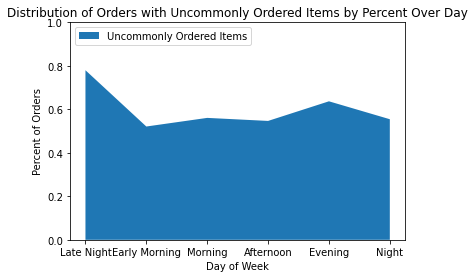

In [332]:
#normalize to show percent by time period
xptab = pd.crosstab(master['Time Number'],master['Uncommon?'], normalize = 'index')*100
#reset to meaningful words rather than ordered numbers
xptab = xptab.rename(index = time_day_cat_dict)
#use column not index as plotting variable
xptab= xptab.reset_index()
display(xptab)
#using default True False column names throws error during plotting
xptab.columns = ['Time of Day','No','Yes']


plt.stackplot(xptab['Time of Day'],xptab['Yes'], labels=['Uncommonly Ordered Items'])
plt.legend(loc='upper left')
plt.xlabel('Day of Week')
plt.ylabel('Percent of Orders')
plt.title('Distribution of Orders with Uncommonly Ordered Items by Percent Over Day')
#it is necessary to customise the range on the y-axis based on subset
#otherwise, variations across domain are very hard to see. I manually tailored each plot. 
plt.ylim(bottom = 0, top = 1)



In [333]:
#investigate what items got categorized as 'missing'
missing = master[master['department_id'] == 21]
missing2 = missing['product_name'].value_counts()
missing2

Organic Riced Cauliflower                   823
Peanut Butter Ice Cream Cup                 261
Organic Celery Bunch                        200
Uncured Beef Hot Dog                        199
Cookie Dough Ice Cream Chocolate Chip       195
                                           ... 
Toasted Coconut Breakfast Biscuits Packs      1
Honey Almond Butter W/ Pretzels               1
Northwest Berry Blend                         1
Roses                                         1
Sausage Maple Pork Patties                    1
Name: product_name, Length: 905, dtype: int64

In [334]:
#create a subset of data for junkfood and query the names of the least ordered items 
junk = master[master['JunkFood?'] == True]
junk = junk['product_name'].value_counts()
junk[-20:]

Chips Onion Chipotle Garlic                                                   1
Mix-Up Flamin' Hot & Cheezy Mix Flavored Snack Mix                            1
Chocolate Snack Grahams                                                       1
Artisan Ginger Molasses Cookie Ice Cream                                      1
Poppy & Sesame Crackers                                                       1
Spice Drops                                                                   1
Sugar Free Caramel Sundae Syrup                                               1
Strawberries & Cream Bars                                                     1
No Salt Potato Chips                                                          1
Potato Ridges Tangy Barbeque                                                  1
Chocolate                                                                     1
Tamari Brown Sesame Rice Crackers                                             1
Turtle Sundae Mix                       

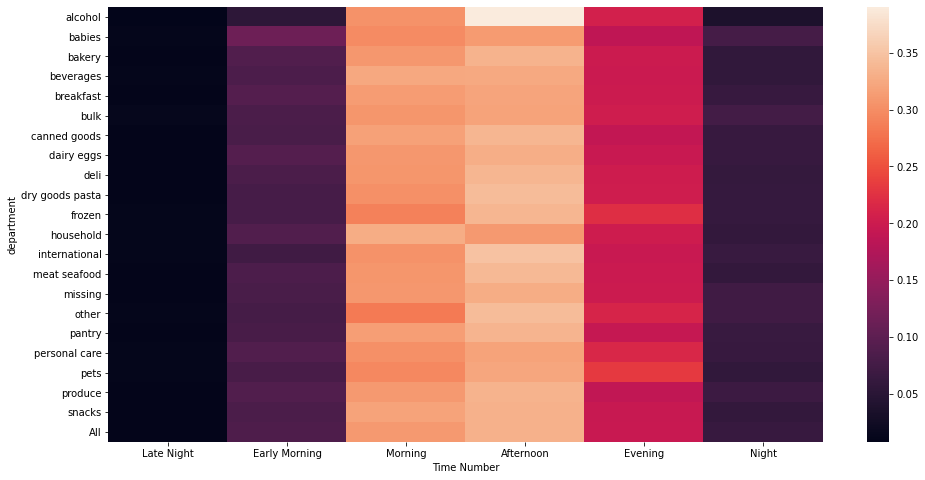

In [335]:
#investigatory heatmat, to aid in feature engineering
f, ax = plt.subplots(figsize=(16, 8))
ax = sns.heatmap(dept_time, )
